In [1]:
import re
import string
import numpy as np
import pandas as pd
import random
import missingno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix

from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer

In [2]:
df = pd.read_csv("fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Exploratory Analysis

In [3]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [4]:
df = df.drop(['department', 'salary_range'], axis=1)
df.head()

,job_id,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


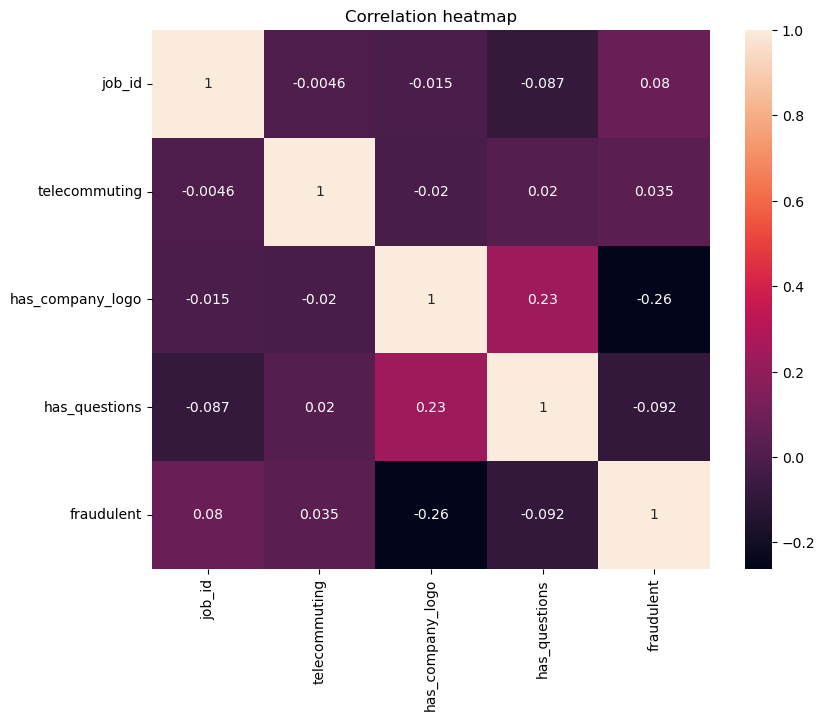

In [5]:
fig = plt.figure(figsize=(9,7))
correlation_matrix = df._get_numeric_data().corr()
sns.heatmap(correlation_matrix, annot=True)
ax = plt.title("Correlation heatmap")

95.1565995525727% of samples are classified as genuine


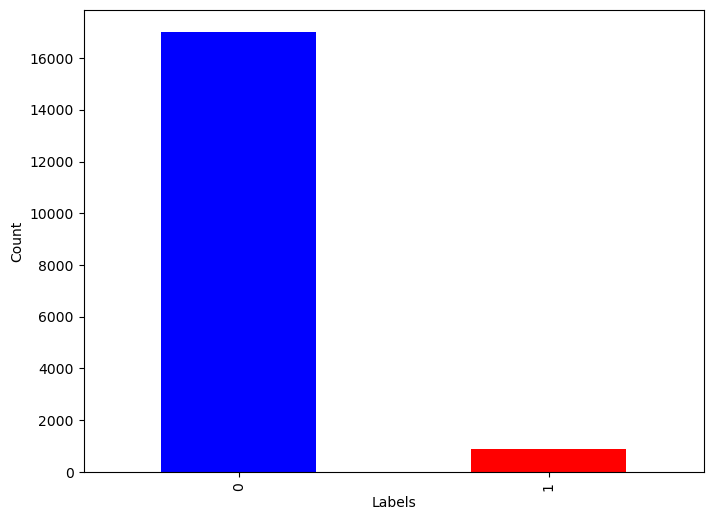

In [6]:
plt.figure()

label_counts = df["fraudulent"].value_counts()

label_counts.plot.bar(color=['blue', 'red'], figsize=(8, 6))
plt.xlabel("Labels")
plt.ylabel("Count")

percentage_real = (label_counts[0] / (label_counts[1] + label_counts[0])) * 100
print(f'{percentage_real}% of samples are classified as genuine')

Text(0.5, 1.0, 'Number of Jobs per Country')

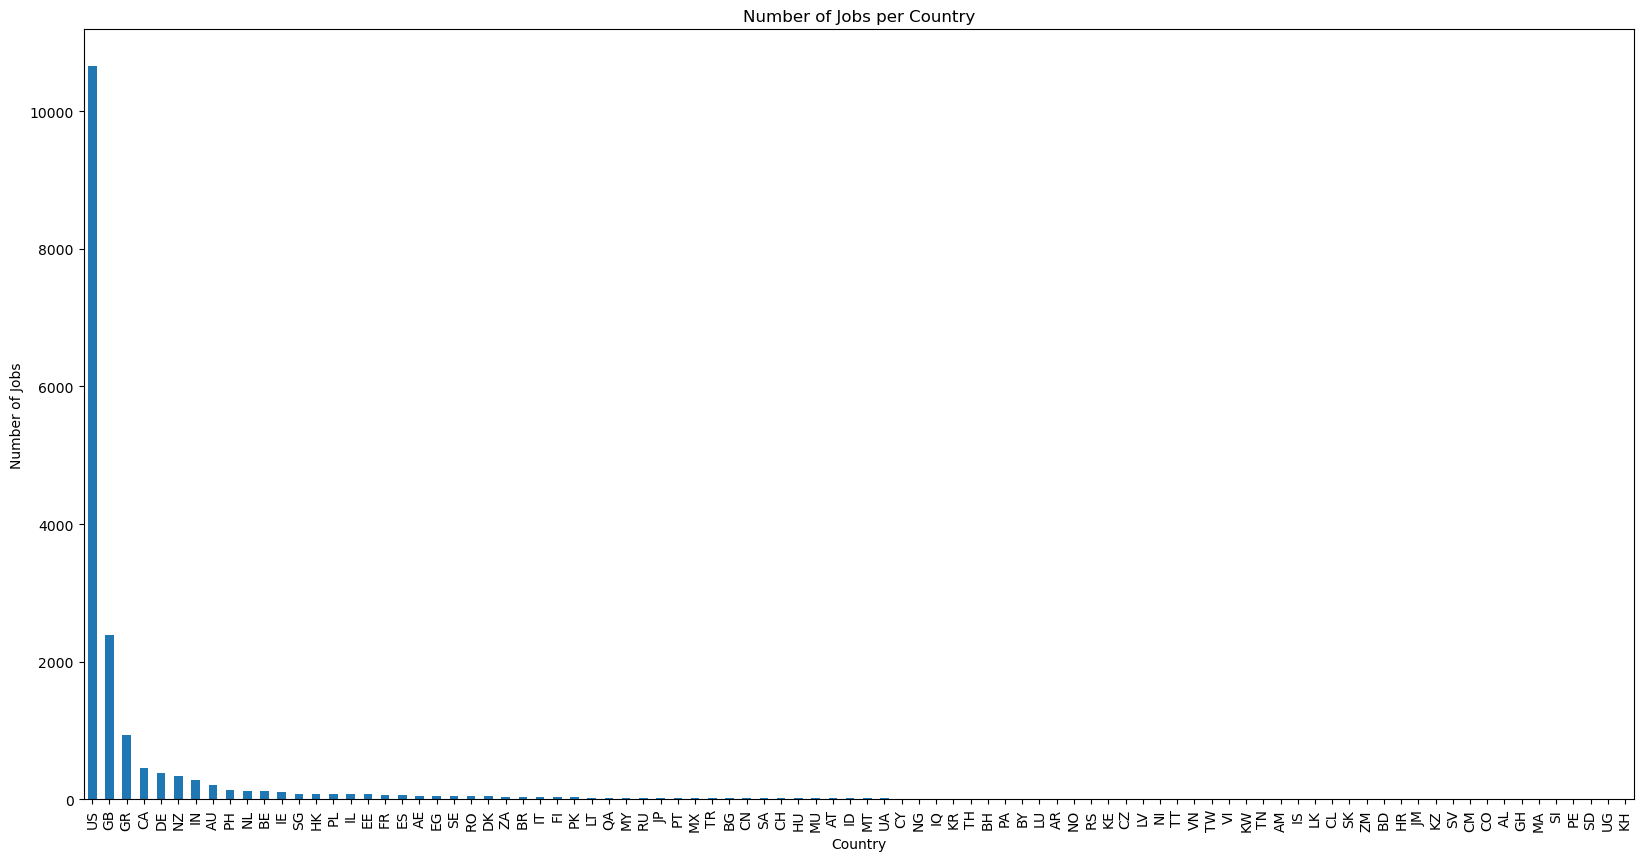

In [7]:
plt.figure(figsize=(20, 10))

country_counts = df['location'].str.split(pat=', ', n=1, expand=True)[0].value_counts()

country_counts.plot.bar()
plt.xlabel("Country")
plt.ylabel("Number of Jobs")
plt.title("Number of Jobs per Country")

Since most of the samples are from the US, we are only using data from US

In [8]:
df = df[df['location'].str.split(pat=', ', n=1, expand=True)[0] == "US"]
df.head(3)

,job_id,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0


We also dissected the location to country, state & city

In [9]:
loc = df['location'].str.split(pat=', ', n=2, expand=True)

df.insert(2, "country", loc[0])
df.insert(3, "state", loc[1])
df.insert(4, "city", loc[2])

df = df.drop(['location'], axis=1)
df.head()

,job_id,title,country,state,city,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,US,NY,New York,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,3,Commissioning Machinery Assistant (CMA),US,IA,Wever,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,US,DC,Washington,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,US,FL,Fort Worth,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,US,MD,,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0


We also removed any sort of null values

In [10]:
df = df[df["state"] != ""]
df = df[df['state'].notna()]
df = df[df["city"] != ""]
df = df[df['city'].notna()]

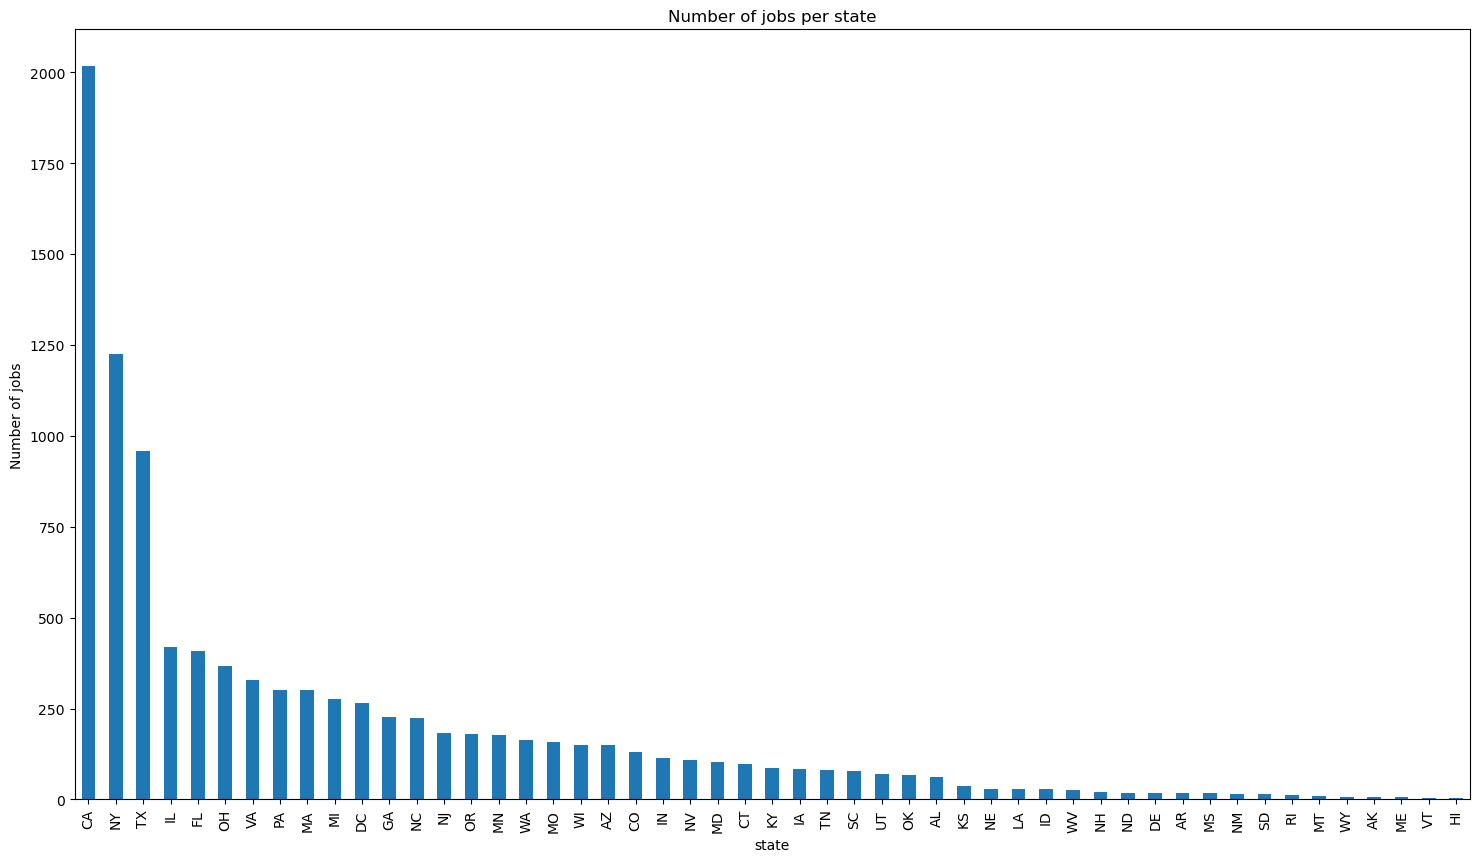

In [11]:
plt.figure(figsize=(18, 10))
df['state'].str.split(pat=', ', n=1, expand=True)[0].value_counts().plot.bar()
plt.xlabel("state")
plt.ylabel("Number of jobs")
ax = plt.title("Number of jobs per state")

Below is a comparison of fake & real jobs in the states

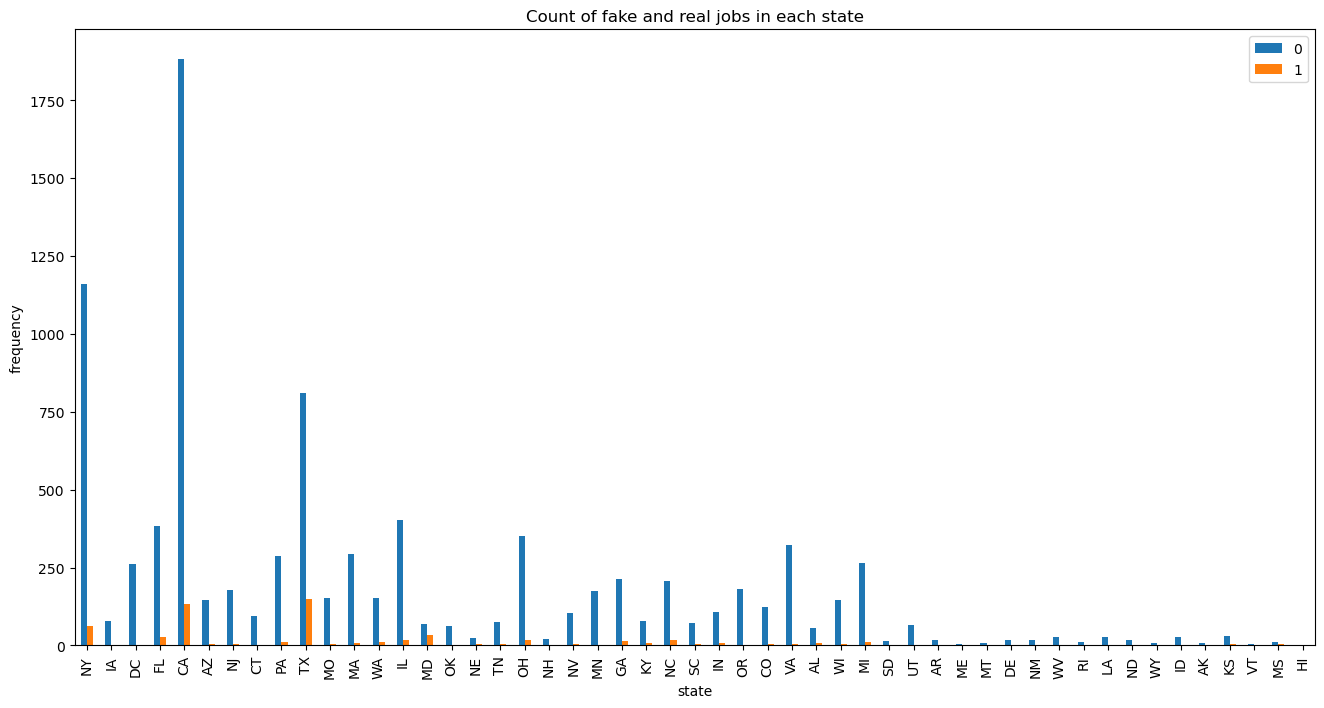

In [12]:
data_freq = []
for state in df["state"].unique():
    filter_state = df[df["state"] == state]
    data_freq.append([len(filter_state[filter_state["fraudulent"] == 0]), len(filter_state[filter_state["fraudulent"] == 1])])

df_grouped = pd.DataFrame(data_freq, index=df["state"].unique())
df_grouped.plot.bar(figsize=(16, 8))
plt.xlabel("state")
plt.ylabel("frequency")
ax = plt.title("Count of fake and real jobs in each state")


We then manually explored relations between fake jobs and type of variables.
Fake jobs are typically full time, entry level, engineering and administrative positions requiring high school level of education. Fake job postings are more commonly made by companies without a logo.

In [13]:
def func(df, col):
    data_freq = []
    label = []
    for u in df[col].unique():
        if u is not np.nan:
            filter_ = df[df[col] == u]
            data_freq.append([len(filter_[filter_["fraudulent"] == 0]), len(filter_[filter_["fraudulent"] == 1])])
            label.append(u)

    df_grouped = pd.DataFrame(data_freq, index=label)
    df_grouped.plot.bar(figsize=(8, 3))
    plt.title(f"Number fake and real jobs by {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

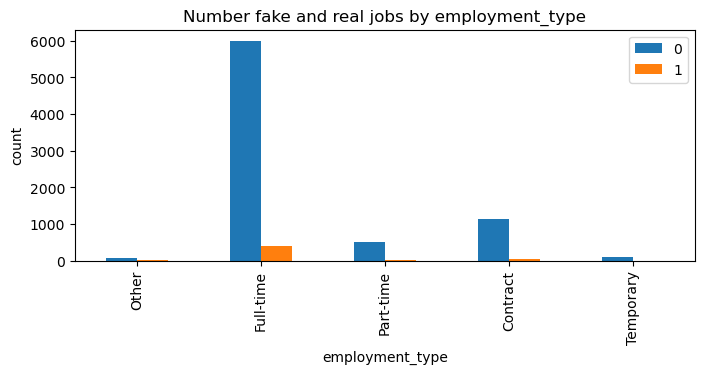

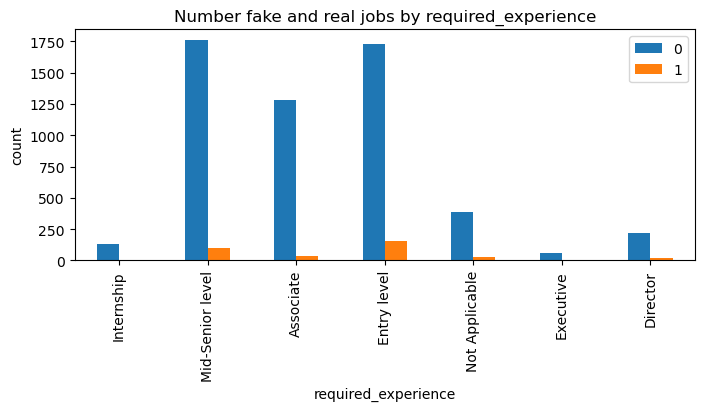

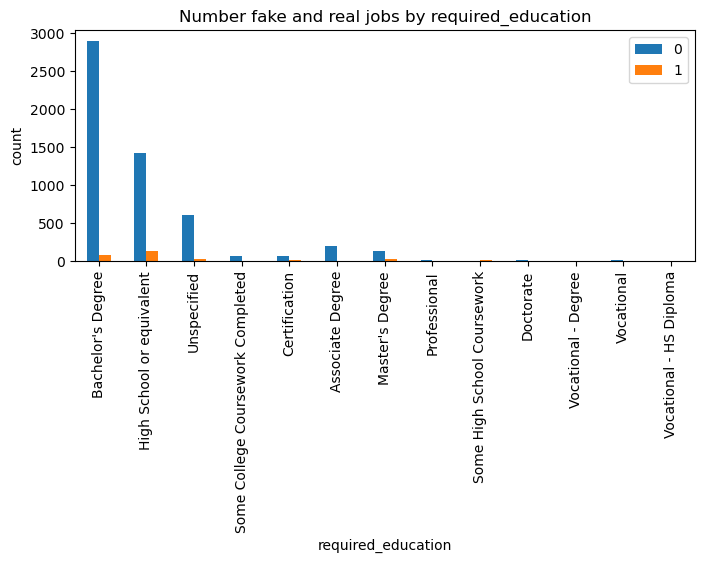

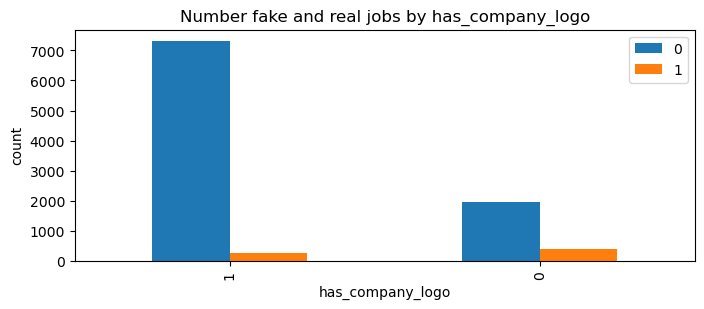

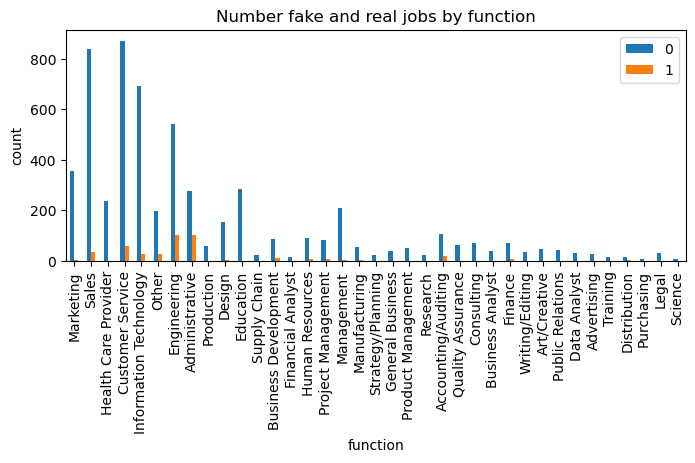

In [14]:
func(df, "employment_type")
func(df, "required_experience")
func(df, "required_education")
func(df, "has_company_logo")
func(df, "function")

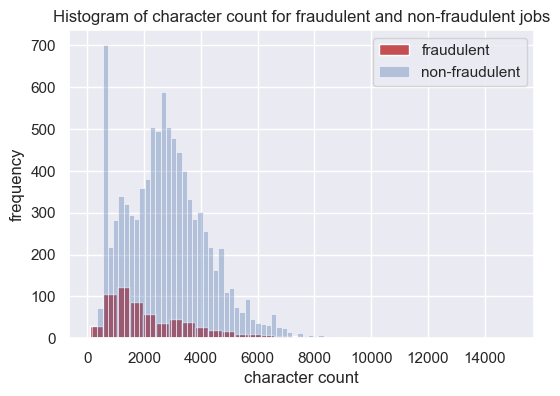

In [15]:
df = df.reset_index().drop(["index"], axis=1)

fraud = df[df["fraudulent"] == 1].apply(lambda row: sum(len(str(row[col])) for col in df.columns), axis=1)
real = df[df["fraudulent"] == 0].apply(lambda row: sum(len(str(row[col])) for col in df.columns), axis=1)

sns.set(rc={'figure.figsize':(6,4)})
sns.histplot(fraud, alpha=1, label="fraudulent", color='r')
sns.histplot(real, alpha=0.35, label="non-fraudulent", color='b')
plt.legend(["fraudulent", "non-fraudulent"])
plt.xlabel("character count")
plt.ylabel("frequency")
plt.title("Histogram of character count for fraudulent and non-fraudulent jobs")
plt.show()

### The histogram shows that real jobs generally have a much larger word count than fake jobs.

In [16]:
df.head()

,job_id,title,country,state,city,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,US,NY,New York,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,3,Commissioning Machinery Assistant (CMA),US,IA,Wever,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
2,4,Account Executive - Washington DC,US,DC,Washington,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
3,5,Bill Review Manager,US,FL,Fort Worth,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
4,8,Lead Guest Service Specialist,US,CA,San Francisco,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0


In [17]:
print(df.columns)

Index(['job_id', 'title', 'country', 'state', 'city', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


In [18]:
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type']
for col in columns:
    del df[col]

df.fillna(' ', inplace=True)

In [19]:
df.head()

,title,country,state,city,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,US,NY,New York,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Commissioning Machinery Assistant (CMA),US,IA,Wever,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
2,Account Executive - Washington DC,US,DC,Washington,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
3,Bill Review Manager,US,FL,Fort Worth,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
4,Lead Guest Service Specialist,US,CA,San Francisco,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,,,,,0


In [20]:
df['text']=df['title']+' '+df['country']+' '+df['state']+' '+df['city']+' '+ df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']
del df['title']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']
del df['state']
del df['city']

In [21]:
df.head()

,fraudulent,text
0,0,"Marketing Intern US NY New York We're Food52, ..."
1,0,Commissioning Machinery Assistant (CMA) US IA ...
2,0,Account Executive - Washington DC US DC Washin...
3,0,Bill Review Manager US FL Fort Worth SpotSourc...
4,0,Lead Guest Service Specialist US CA San Fra...


In [22]:
fraudjobs_text = df[df.fraudulent==1].text
realjobs_text = df[df.fraudulent==0].text

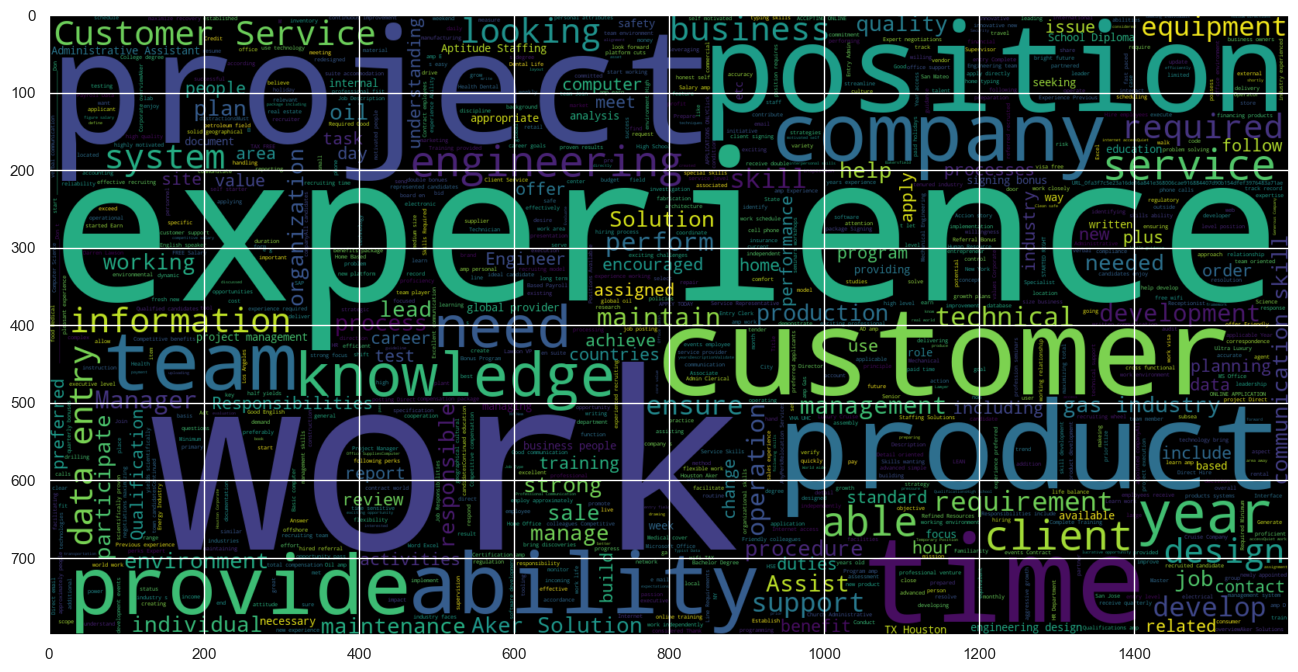

In [23]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

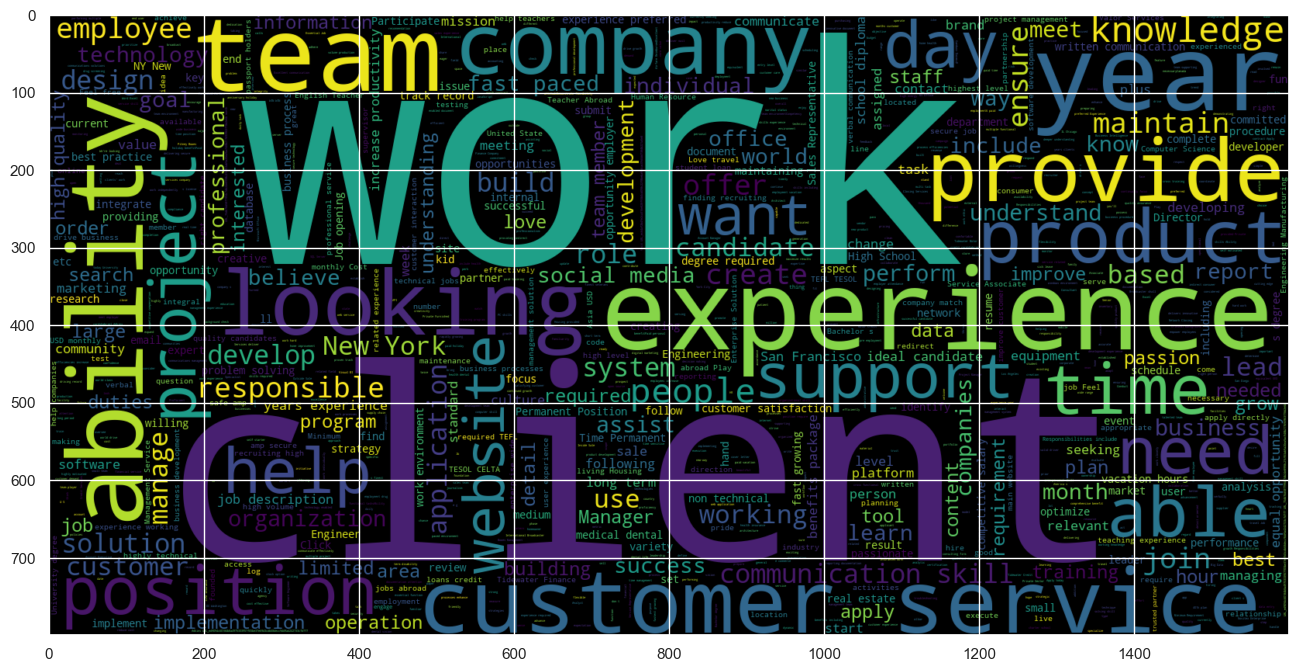

In [27]:
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(realjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

## Data Cleaning

In [23]:
!pip install spacy

!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [24]:
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS


# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    #mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    
   


    # return preprocessed list of tokens
    return mytokens

In [33]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [34]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.fraudulent, test_size=0.3)

Accuracy:  0.9356469002695418
Recall:  0.0


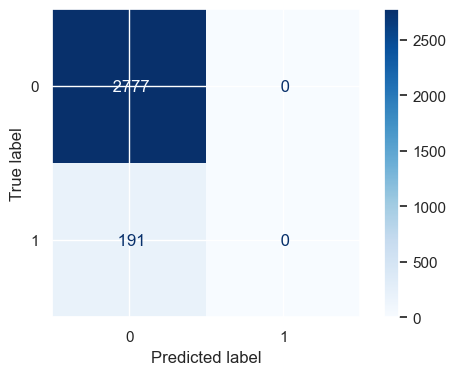

In [41]:
pipe = Pipeline([("cleaner", predictors()),
                  ('vectorizer', bow_vector),
                  ('classifier', LogisticRegression())])

  
pipe.fit(X_train, y_train)

  
predicted = pipe.predict(X_test)

  
print( "Accuracy: " , accuracy_score(y_test, predicted))
print( "Recall: ", recall_score(y_test, predicted))

  #plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

Accuracy:  0.9336253369272237
Recall:  0.12041884816753927


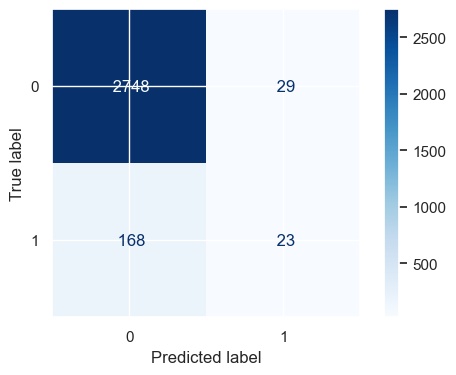

In [44]:
#3Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                  ('vectorizer', bow_vector),
                  ('classifier', RandomForestClassifier())])

  # Fitting model
pipe.fit(X_train, y_train)

  # Predicting with a test dataset
predicted = pipe.predict(X_test)

  # Model Accuracy
print( "Accuracy: " , accuracy_score(y_test, predicted))
print( "Recall: ", recall_score(y_test, predicted))

  #plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

Accuracy:  0.9356469002695418
Recall:  0.0


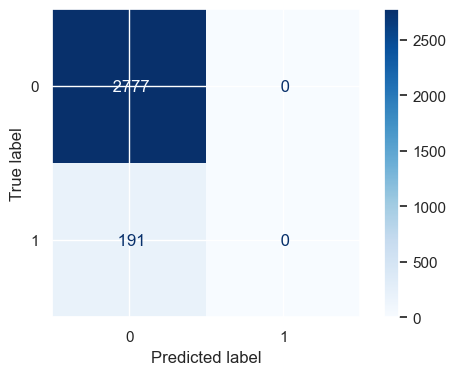

In [39]:
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                  ('vectorizer', bow_vector),
                  ('classifier', SVC())])

  # Fitting model
pipe.fit(X_train, y_train)

  # Predicting with a test dataset
predicted = pipe.predict(X_test)

  # Model Accuracy
print( "Accuracy: " , accuracy_score(y_test, predicted))
print( "Recall: ", recall_score(y_test, predicted))

  #plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')

Accuracy:  0.9363207547169812
Recall:  0.07329842931937172


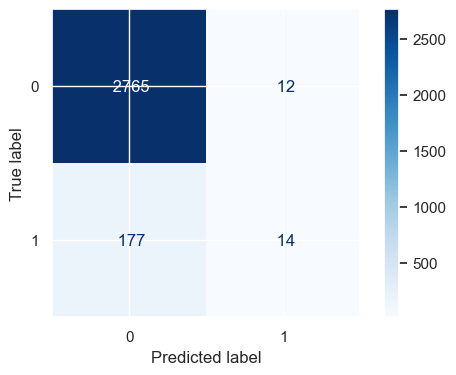

In [40]:
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                  ('vectorizer', bow_vector),
                  ('classifier', XGBClassifier())])

  # Fitting model
pipe.fit(X_train, y_train)

  # Predicting with a test dataset
predicted = pipe.predict(X_test)

  # Model Accuracy
print( "Accuracy: " , accuracy_score(y_test, predicted))
print( "Recall: ", recall_score(y_test, predicted))

  #plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format=' ')